# Bayes By Backprop - Mean Field Variational Inference

## Theoretic Foundation

## Imports

In [1]:
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import BNN_VI_ELBO_Classification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_two_moons_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = TwoMoonsDataModule(batch_size=128)

X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

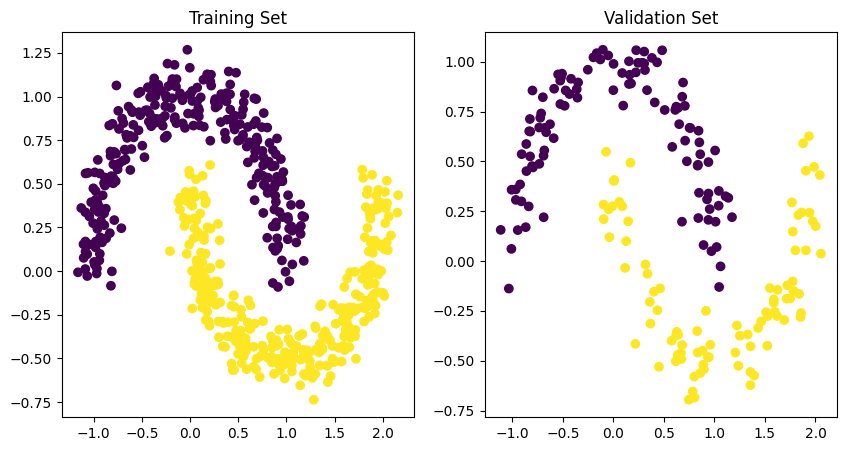

In [5]:
plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP).

In [6]:
network = MLP(n_inputs=2, n_hidden=[50, 50], n_outputs=2, activation_fn=nn.ReLU())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [7]:
bbp_model = BNN_VI_ELBO_Classification(
    network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    criterion=nn.CrossEntropyLoss(),
    num_training_points=X_train.shape[0],
    num_mc_samples_train=10,
    num_mc_samples_test=25,
)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(


## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=200,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [9]:
trainer.fit(bbp_model, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.6 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

Index(['val_loss', 'valAcc', 'valF1Score', 'epoch', 'step', 'trainAcc',
       'trainF1Score', 'train_loss'],
      dtype='object')


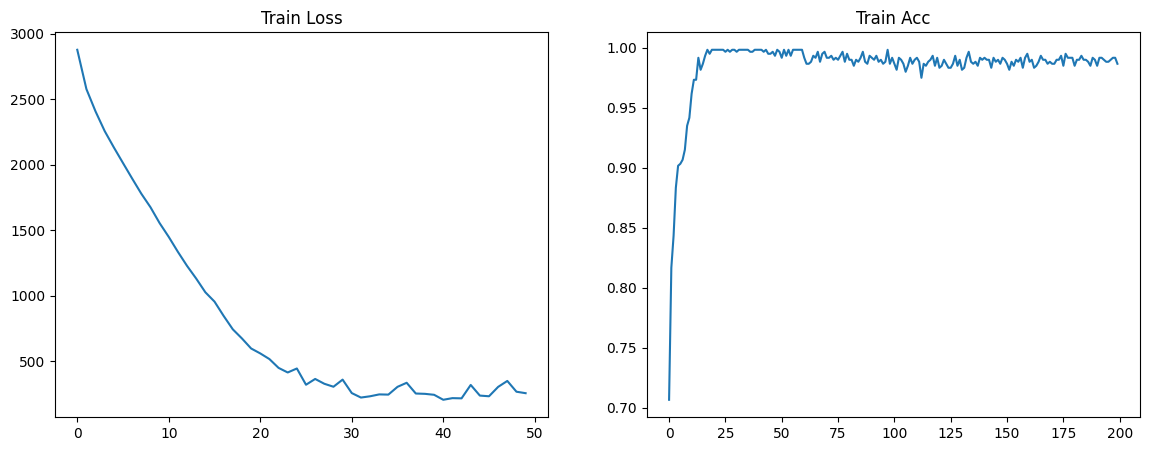

In [10]:
fig = plot_training_metrics(my_temp_dir, "Acc")

## Prediction

In [11]:
preds = bbp_model.predict_step(test_grid_points)

## Evaluate Predictions

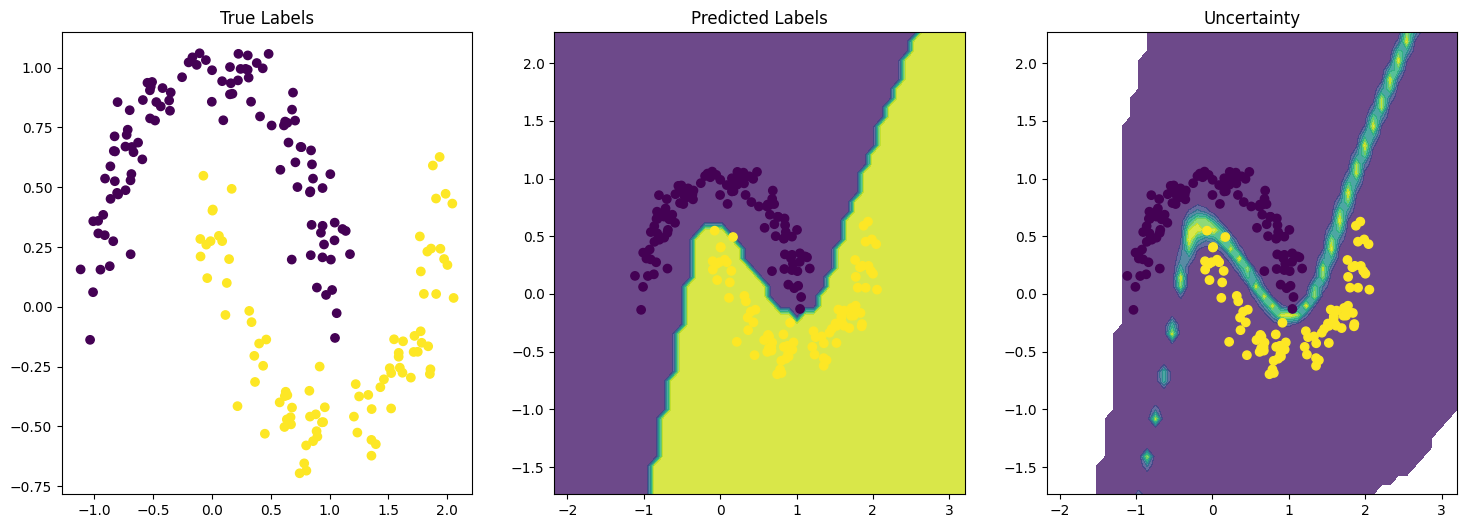

In [12]:
fig = plot_predictions_classification(
    X_test, y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)